In [1]:
import os
from pathlib import Path
import yfinance as yf
import json
import matplotlib.pyplot as plt
from typing import Optional, TypeAlias


import pandas as pd
import numpy as np

from strategy_portfolio_opt.constrained_min import ConstrainedMin

In [11]:
tickers = {
    "tech": ["AAPL", "MSFT", "TSLA"],
    "healthcare": ["JNJ", "PFE", "MRK"],
    "financials": ["JPM", "BAC", "WFC"],
    "energy": ["XOM", "CVX", "SLB"],
    "consumer": ["PG", "KO", "WMT"],
    "commodities": ["GC=F", "CL=F"]
}

TEST_CUTOFF = pd.Timestamp("2024-01-01", tz="UTC")

In [3]:
for sector, symbols in tickers.items():
    print(f"Fetching data for {sector} sector...")
    for symbol in symbols:
        try:
            ticker_data = yf.Ticker(symbol)
            hist = ticker_data.history(start="2010-01-01")
            
            mask_test = hist.index >= TEST_CUTOFF
            df_test = hist.loc[mask_test].copy()
            df_train = hist.loc[~mask_test].copy()

            train_path = f"historical_data/{symbol}_train.csv"
            test_path  = f"historical_data/{symbol}_test.csv"
            
            df_train.to_csv(train_path)
            df_test.to_csv(test_path)
            print(f"Split '{symbol}' →")
            print(f"    TRAIN ({len(df_train)} rows) → {train_path}")
            print(f"    TEST  ({len(df_test)} rows) → {test_path}")

            print(f"{symbol} data fetched successfully.")
        except Exception as e:
            print(f"Error fetching data for {symbol}: {e}")
    print(f"Finished fetching data for {sector} sector.\n")

Fetching data for tech sector...
Split 'AAPL' →
    TRAIN (3522 rows) → historical_data/AAPL_train.csv
    TEST  (359 rows) → historical_data/AAPL_test.csv
AAPL data fetched successfully.
Split 'MSFT' →
    TRAIN (3522 rows) → historical_data/MSFT_train.csv
    TEST  (359 rows) → historical_data/MSFT_test.csv
MSFT data fetched successfully.
Split 'TSLA' →
    TRAIN (3400 rows) → historical_data/TSLA_train.csv
    TEST  (359 rows) → historical_data/TSLA_test.csv
TSLA data fetched successfully.
Finished fetching data for tech sector.

Fetching data for healthcare sector...
Split 'JNJ' →
    TRAIN (3522 rows) → historical_data/JNJ_train.csv
    TEST  (359 rows) → historical_data/JNJ_test.csv
JNJ data fetched successfully.
Split 'PFE' →
    TRAIN (3522 rows) → historical_data/PFE_train.csv
    TEST  (359 rows) → historical_data/PFE_test.csv
PFE data fetched successfully.
Split 'MRK' →
    TRAIN (3522 rows) → historical_data/MRK_train.csv
    TEST  (359 rows) → historical_data/MRK_test.csv


In [6]:
def moving_average_crossover(df: pd.DataFrame,
                             short_window: int = 20,
                             long_window: int = 50) -> pd.DataFrame:
    """
    Compute a simple moving‐average crossover strategy on `df`.
    Assumes `df` has a 'Date' column (or datetime index) and a 'Close' column.

    Parameters
    ----------
    df : pd.DataFrame
        Must contain 'Date' (or be indexed by datetime) and 'Close'.
    short_window : int
        Window size for the short SMA (e.g., 20 days).
    long_window : int
        Window size for the long SMA (e.g., 50 days).

    Returns
    -------
    pd.DataFrame
        Original DataFrame with the following added columns:
          - 'SMA_short' : short‐period moving average
          - 'SMA_long'  : long‐period moving average
          - 'Signal'    : 1 when short crosses above long,
                          -1 when short crosses below long, else 0
    """

    df = df.copy()

    # Ensure 'Date' is a datetime type and set as index if not already
    if "Date" in df.columns:
        df["Date"] = pd.to_datetime(df["Date"], errors="raise", utc=True)
        df.set_index("Date", inplace=True)
    elif not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("DataFrame must have a 'Date' column or be indexed by datetime.")

    # 1) Compute Simple Moving Averages
    df["SMA_short"] = df["Close"].rolling(window=short_window, min_periods=1).mean()
    df["SMA_long"]  = df["Close"].rolling(window=long_window, min_periods=1).mean()

    # 2) Generate raw crossover signals: 
    #    - When SMA_short > SMA_long → 1 (long), when SMA_short < SMA_long → 0
    df["Crossover"] = np.where(df["SMA_short"] > df["SMA_long"], 1, 0)

    # 3) The actual “Signal” is the change in Crossover:
    #    - A rising edge (0→1) means a buy signal (1)
    #    - A falling edge (1→0) means a sell signal (−1)
    df["Signal"] = df["Crossover"].diff().fillna(0)
    df["Signal"] = df["Signal"].map({1.0: 1, -1.0: -1}).fillna(0).astype(int)

    # Rows where no crossover event happen remain at 0
    # Cleanup temporary column if you don’t need it:
    df.drop(columns=["Crossover"], inplace=True)

    return df

In [7]:
def bollinger_bands_strategy(df: pd.DataFrame,
                             window: int = 20,
                             num_std: float = 2.0) -> pd.DataFrame:
    """
    Compute a simple Bollinger Bands breakout strategy on `df`.
    Assumes `df` has a 'Date' column (or datetime index) and a 'Close' column.

    Parameters
    ----------
    df : pd.DataFrame
        Must contain 'Date' (or be indexed by datetime) and 'Close'.
    window : int
        Rolling window size for moving average and standard deviation.
    num_std : float
        Number of standard deviations for upper/lower bands.

    Returns
    -------
    pd.DataFrame
        Original DataFrame with these added columns:
          - 'BB_mid'   : rolling mean (middle band)
          - 'BB_std'   : rolling standard deviation
          - 'BB_upper' : BB_mid + num_std * BB_std
          - 'BB_lower' : BB_mid − num_std * BB_std
          - 'Signal'   :  1 when Close < BB_lower (buy)
                          -1 when Close > BB_upper (sell), else 0
    """

    df = df.copy()

    # Ensure 'Date' is datetime and set as index if needed
    if "Date" in df.columns:
        df["Date"] = pd.to_datetime(df["Date"], errors="raise", utc=True)
        df.set_index("Date", inplace=True)
    elif not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("DataFrame must have a 'Date' column or be indexed by datetime.")

    # 1) Compute rolling mean (mid) and rolling std (std) over 'window'
    df["BB_mid"] = df["Close"].rolling(window=window, min_periods=1).mean()
    df["BB_std"] = df["Close"].rolling(window=window, min_periods=1).std(ddof=0)

    # 2) Compute upper and lower bands
    df["BB_upper"] = df["BB_mid"] + (num_std * df["BB_std"])
    df["BB_lower"] = df["BB_mid"] - (num_std * df["BB_std"])

    # 3) Generate signals:
    #    - Buy (1)  when price closes below the lower band
    #    - Sell (-1) when price closes above the upper band
    conditions = [
        df["Close"] < df["BB_lower"],  # price has broken below lower band
        df["Close"] > df["BB_upper"],  # price has broken above upper band
    ]
    choices = [1, -1]

    df["Signal"] = np.select(conditions, choices, default=0).astype(int)

    return df

In [8]:
def backtest(
    df: pd.DataFrame,
    price_col: str = "Close",
    signal_col: str = "Signal"
) -> list[float]:
    """
    Backtest a strategy that can go long (signal=+1), short (signal=-1), or flat (signal=0).
    For each change in signal, it closes any open position and (if new signal != 0) opens a new position.
    Returns a list of percent PnLs for each completed trade.

    Parameters
    ----------
    df : pd.DataFrame
        Must be sorted in ascending date order and contain:
          - price_col   : price at which to execute trades (float)
          - signal_col  : integer signal (+1=open long, -1=open short, 0=flat)
    price_col : str
        Name of the column with execution prices.
    signal_col : str
        Name of the column with signals (+1, -1, 0).

    Returns
    -------
    List[float]
        Percent PnLs for each round-trip (long or short) trade.
    """
    pnls: list[float] = []
    current_position = 0   # +1 for long, -1 for short, 0 for flat
    entry_price = None     # price at which the current position was opened

    for idx, row in df.iterrows():
        sig = int(row[signal_col])
        price = float(row[price_col])

        # If the signal changes from whatever we currently hold:
        if sig != current_position:
            # 1) Close any existing position
            if current_position != 0 and entry_price is not None:
                if current_position == 1:
                    # closing a long
                    pnl = (price - entry_price) / entry_price * 100.0
                else:  # current_position == -1, closing a short
                    pnl = (entry_price - price) / entry_price * 100.0

                pnls.append(pnl)
                entry_price = None
                current_position = 0

            # 2) Open a new position if sig != 0
            if sig != 0:
                current_position = sig
                entry_price = price

        # If sig == current_position, do nothing (hold the position)
        # If sig == 0 and current_position == 0, do nothing (remain flat)

    # At the end: if a position is still open, close it at the last price
    if current_position != 0 and entry_price is not None:
        last_price = float(df.iloc[-1][price_col])
        if current_position == 1:
            pnl = (last_price - entry_price) / entry_price * 100.0
        else:  # current_position == -1
            pnl = (entry_price - last_price) / entry_price * 100.0

        pnls.append(pnl)

    return pnls

In [9]:
def generate_backtest_pnl(split: str) -> pd.DataFrame: 
    pnls = {}
    for sector, symbols in tickers.items():
        print(f"Processing strategies for {sector} sector...")
        for symbol in symbols:
            try:
                file_path = Path(f"historical_data/{symbol}_{split}.csv")
                if not file_path.exists():
                    print(f"File {file_path} does not exist. Skipping.")
                    continue

                df = pd.read_csv(file_path)

                # Apply moving average crossover strategy
                df_ma = moving_average_crossover(df)
                ma_pnls = backtest(df_ma)
                print(f"{symbol} MA Strategy PnLs: {ma_pnls}")

                pnls[f"{symbol}_ma_startegy"] = pd.Series(ma_pnls)

                # Apply Bollinger Bands strategy
                df_bb = bollinger_bands_strategy(df)
                bb_pnls = backtest(df_bb)
                print(f"{symbol} BB Strategy PnLs: {bb_pnls}")

                pnls[f"{symbol}_bb_strategy"] = pd.Series(bb_pnls)

            except Exception as e:
                print(f"Error processing {symbol}: {e}")
        print(f"Finished processing strategies for {sector} sector.\n")
    return pd.DataFrame(pnls)

In [12]:
train_pnls = generate_backtest_pnl("train")
train_pnls

Processing strategies for tech sector...
AAPL MA Strategy PnLs: [0.8160751262632101, -0.30374989743887904, -1.4229828918795129, -0.35518536576999504, 0.1906620413924177, 1.133417445303319, -1.7514896291341224, -3.0882218235119456, 1.9985101286506304, 0.654445386583777, 0.6159429741275884, -0.23544371149203028, 0.22074461194902936, 1.8569495102424702, 2.2319212919843503, 1.0777224877470344, 0.9170567223379108, -0.9771558053122652, 0.6764684581177447, 1.1352489001517299, 0.09701209351437858, -0.8846580448609049, 1.0756474972339816, 1.3070999383362254, 3.87275728838948, -2.1398791118032627, 0.5620950608807737, -0.009413786162589765, -0.8421089407631792, 1.125443763159022, -1.470616843720719, 1.751503791275397, 4.120465051666692, -1.226072857539232, 1.0773733829626977, 0.5576980273278299, -2.809554493018926, -1.6840447612155782, 0.3033125808726614, -0.4537097321318394, -0.6882969710406528, -2.688839438223777, -0.6577734648278412, -1.4610465079181325, -0.999110070213678, -0.4355856160656956

,AAPL_ma_startegy,AAPL_bb_strategy,MSFT_ma_startegy,MSFT_bb_strategy,TSLA_ma_startegy,TSLA_bb_strategy,JNJ_ma_startegy,JNJ_bb_strategy,PFE_ma_startegy,PFE_bb_strategy,...,PG_ma_startegy,PG_bb_strategy,KO_ma_startegy,KO_bb_strategy,WMT_ma_startegy,WMT_bb_strategy,GC=F_ma_startegy,GC=F_bb_strategy,CL=F_ma_startegy,CL=F_bb_strategy
0,0.816075,2.690217,-0.769742,1.243074,-4.205355,-3.730999,-0.108897,0.031672,-2.308538,-0.884949,...,-0.397397,0.210742,0.182572,-0.036734,-0.236215,0.144330,-1.265593,-0.680149,-0.464156,0.965926
1,-0.303750,1.390238,4.001444,0.816195,-5.392702,0.047514,1.082419,1.035213,0.449401,0.300028,...,0.062879,0.951749,-0.707480,0.339844,-0.186455,-1.145097,-0.829318,0.310611,0.942780,-1.391356
2,-1.422983,0.066959,-1.643719,0.067476,2.726774,4.731550,0.657155,0.359142,1.732659,0.865602,...,-0.602427,0.437385,0.903073,1.229636,0.604420,-0.836227,0.048565,0.376628,2.903579,-2.531035
3,-0.355185,-2.991538,-0.461786,-1.087680,-0.743629,7.142813,-0.033436,-0.076846,0.178199,0.348220,...,-0.083342,1.425651,-0.764737,0.926787,-0.222370,0.136445,-0.052537,-0.807075,3.721551,-3.963984
4,0.190662,-0.440299,0.409368,0.095679,-3.927946,1.968886,0.393118,0.562570,0.056840,1.867432,...,-0.610386,0.367970,0.015332,0.707480,-0.199559,0.835311,0.454323,0.974494,0.495054,-3.072192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.966195,...,NaN,NaN,NaN,-0.972933,NaN,NaN,NaN,NaN,NaN,NaN
224,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.279834,...,NaN,NaN,NaN,-0.793090,NaN,NaN,NaN,NaN,NaN,NaN
225,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.112524,...,NaN,NaN,NaN,0.954567,NaN,NaN,NaN,NaN,NaN,NaN
226,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-0.741001,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
expected_returns = train_pnls.mean().values
cov_mat = train_pnls.cov().values
print("Expected Returns shape:", expected_returns.shape)
print("Covariance Matrix shape:", cov_mat.shape)

Expected Returns shape: (34,)
Covariance Matrix shape: (34, 34)


In [14]:
FunctionEvaluationResult: TypeAlias = tuple[float, np.ndarray, Optional[np.ndarray]]


def f_aa(w: np.ndarray, eval_hessian: bool = True) -> FunctionEvaluationResult:
    """
    Asset Allocation function for testing.
    
    Parameters
    ----------
    w : np.ndarray
        Input vector.
    eval_hessian : bool, optional
        Whether to evaluate the Hessian. Default is True.
    Returns
    -------
    FunctionEvaluationResult
        Tuple containing function value, gradient, and Hessian (if eval_hessian is True).
    """
    f_val = w.T @ cov_mat @ w
    grad = 2 * cov_mat @ w
    hess = 2 * cov_mat if eval_hessian else None
    return f_val, grad, hess

# Define the equality constraints for the asset allocation problem: sum of weights equals 1
eq_constraints_mat_aa = np.ones((1, cov_mat.shape[0]))
eq_constraints_rhs_aa = np.array([1.0])

# Solver expectation is g(x) <= 0
# Define the inequality constraints for the asset allocation problem: expected returns >= 5
zero_matrix = np.zeros_like(cov_mat)

ineq_aa = [
    lambda w, eval_hessian=True: (
        0.05 - expected_returns @ w,   # g(w) ≤ 0  ⇔  μᵀw ≥ 0.05
        -expected_returns,
        zero_matrix
    )
]

# ─── w_i ≥ 0   ⇒   g_i(w) = -w_i ≤ 0  for every i ─────────
neg_eye = -np.eye(cov_mat.shape[0])                   # store gradients once

def make_nonneg(i: int) -> callable:
    g_vec = np.zeros(cov_mat.shape[0]);  g_vec[i] = -1      # ∇g_i = -e_i
    def g_i(w, *, eval_hessian=True):
        return -w[i], g_vec, zero_matrix           # g_i(w) ≤ 0  ⇔ w_i ≥ 0
    return g_i

for i in range(cov_mat.shape[0]):
    ineq_aa.append(make_nonneg(i))

In [17]:
def optimize_porfolio():
    solver = ConstrainedMin()
    x0_aa = np.array([0.00507684, 0.01888075, 0.00028216, 0.02339314, 0.06273231, 0.01796624,
            0.00128375, 0.0286506, 0.03837643, 0.01033616, 0.05184716, 0.04885817,
            0.04430015, 0.05347783, 0.05710118, 0.00493745, 0.06086204, 0.04287345,
            0.02064393, 0.00906053, 0.03120323, 0.04730446, 0.01155924, 0.03971751,
            0.04346861, 0.0151178, 0.0055552, 0.04185903, 0.01648399, 0.02915361,
            0.01262438, 0.01934785, 0.06058349, 0.02508133])
    x_star_aa = solver.interior_pt(
        f=f_aa,
        ineq_constraints=ineq_aa,
        eq_constraints_mat=eq_constraints_mat_aa,
        eq_constraints_rhs=eq_constraints_rhs_aa,
        x0=x0_aa
    )
    return x_star_aa

In [18]:
optimal_weights = optimize_porfolio()
print("Optimal Weights:", optimal_weights)

[outer 1] t=1.0e+01, f=0.228556
[outer 2] t=1.0e+02, f=0.18436
[outer 3] t=1.0e+03, f=0.111529
[outer 4] t=1.0e+04, f=0.075826
[outer 5] t=1.0e+05, f=0.0710438
[outer 6] t=1.0e+06, f=0.0705499
[outer 7] t=1.0e+07, f=0.0704968
[outer 8] t=1.0e+08, f=0.0704914
Optimal Weights: [4.18767137e-02 4.75362835e-02 4.76796314e-06 8.85647578e-03
 3.68960946e-03 1.25476227e-03 1.28379330e-01 4.86296322e-02
 1.51197104e-02 3.96612811e-02 3.40622366e-02 2.00183079e-02
 5.49597129e-03 5.91903239e-07 4.30035655e-02 1.00453829e-06
 5.12770606e-02 1.79879765e-02 6.54674306e-02 3.77602777e-02
 6.30824115e-02 8.74998744e-03 8.87620691e-03 5.58840104e-03
 6.62458543e-02 1.96748121e-03 2.03809749e-02 5.59959467e-02
 1.09384935e-05 2.57359171e-02 8.49330614e-02 3.69475740e-02
 1.14015220e-02 7.33386893e-07]


In [23]:
def plot_cumulative_returns(pnls: pd.DataFrame, optimal_weights: np.ndarray, split: str):
    """
    Plot cumulative returns from a DataFrame of PnLs.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing PnLs for each strategy.
    title : str
        Title for the plot.
    """
    # Introduce cumulative returns pd.DataFrame for all the strategies
    cumulative_returns = pd.DataFrame(index=pnls.index)
    for col in pnls.columns:
        cumulative_returns[col] = np.cumsum(pnls[col].fillna(0))
    
    # Plot all cumulative returns on single graph
    plt.figure(figsize=(14, 8))
    for col in cumulative_returns.columns:
        plt.plot(cumulative_returns.index, cumulative_returns[col], label=col)
    plt.title(f"Cumulative Returns of All Strategies - {split}")
    plt.xlabel("Trade Number")
    plt.ylabel("Cumulative Return (%)")
    plt.axhline(0, color='red', linestyle='--', linewidth=1)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

    # Plot the average cumulative return of all strategies graph
    average_cumulative_return = cumulative_returns.mean(axis=1)
    plt.figure(figsize=(14, 8))
    plt.plot(average_cumulative_return.index, average_cumulative_return, label='Average Cumulative Return', color='blue')
    plt.title(f"Average Cumulative Return of All Strategies - {split}")
    plt.xlabel("Trade Number")
    plt.ylabel("Average Cumulative Return (%)")
    plt.axhline(0, color='red', linestyle='--', linewidth=1)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

    # Plot the weighted cumulative return of all strategies graph using optimal weights
    weighted_cumulative_return = (cumulative_returns * optimal_weights).sum(axis=1)
    plt.figure(figsize=(14, 8))
    plt.plot(weighted_cumulative_return.index, weighted_cumulative_return, label='Weighted Cumulative Return', color='green')
    plt.title(f"Weighted Cumulative Return of All Strategies - {split}")
    plt.xlabel("Trade Number")
    plt.ylabel("Weighted Cumulative Return (%)")
    plt.axhline(0, color='red', linestyle='--', linewidth=1)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

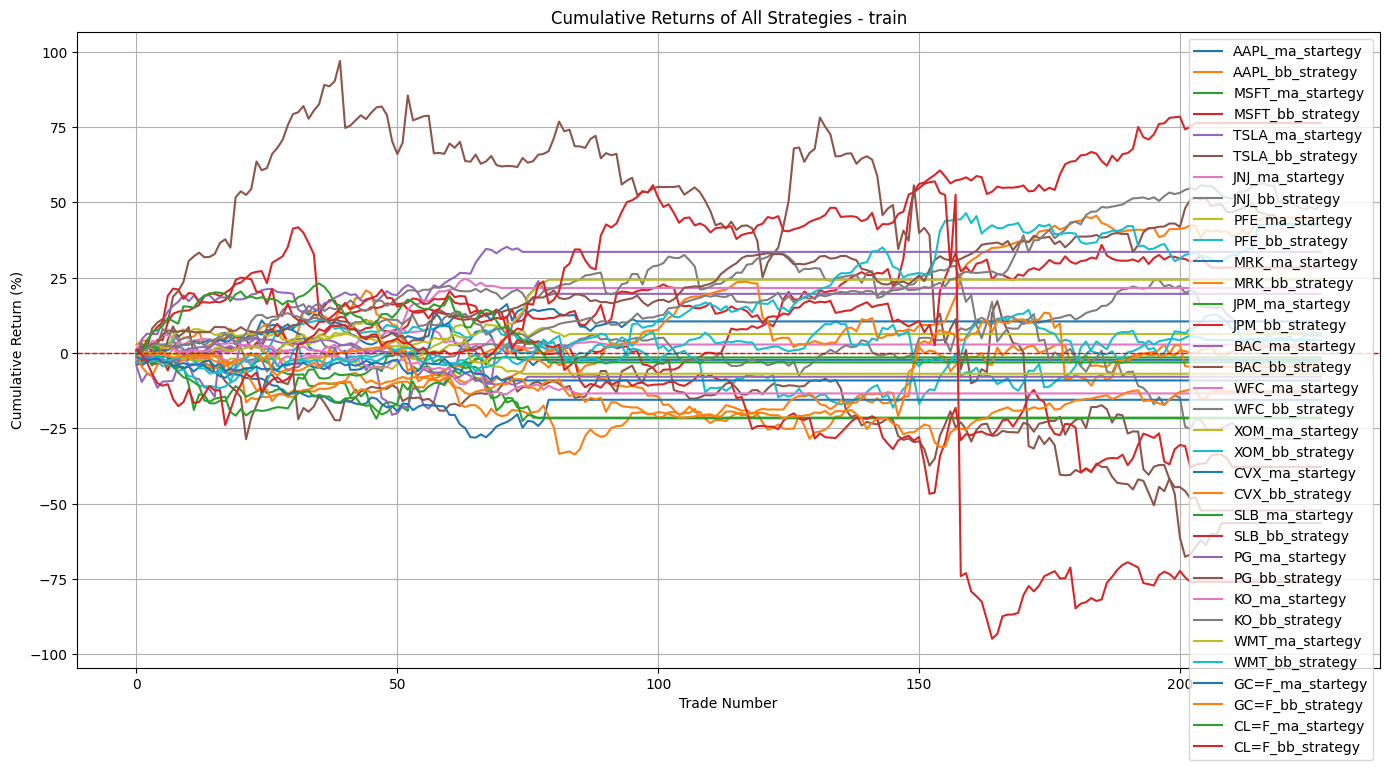

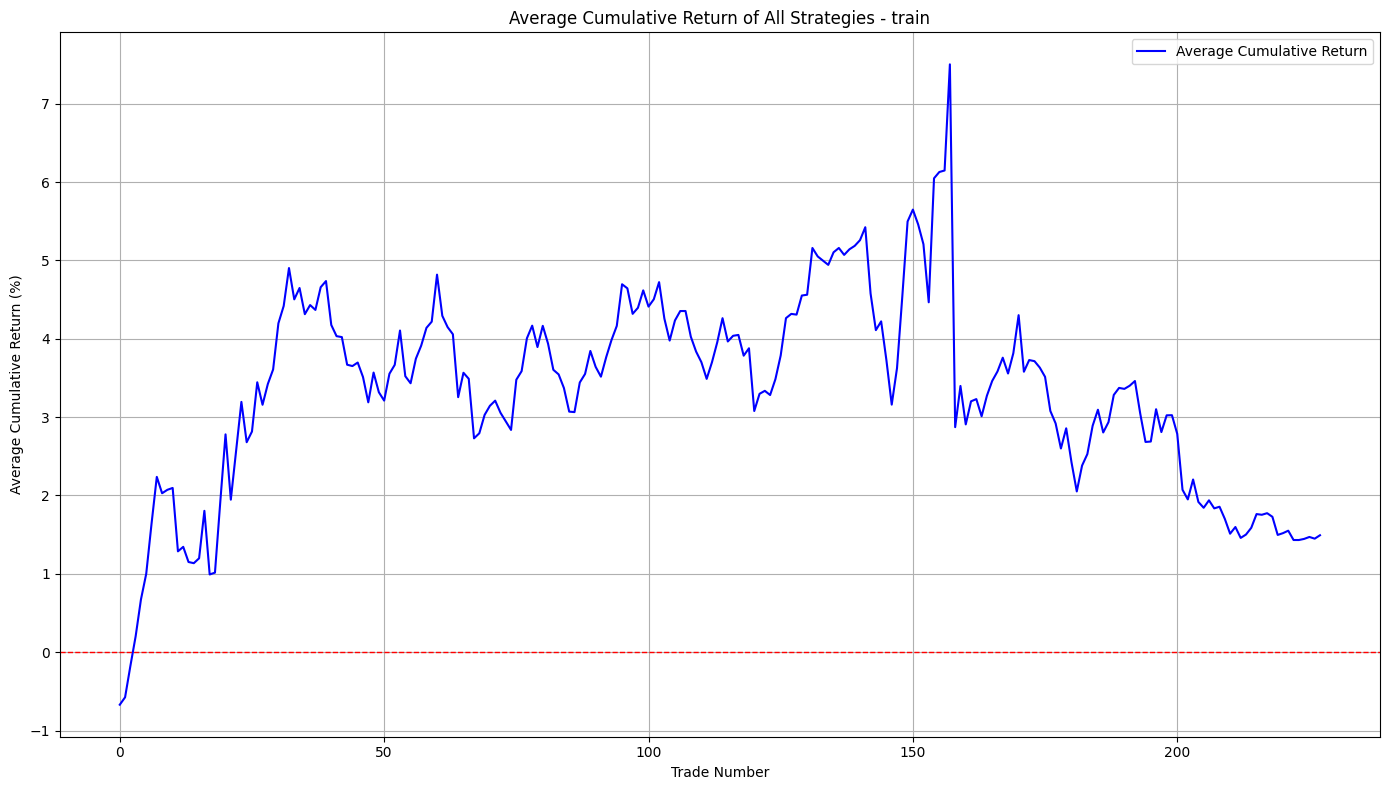

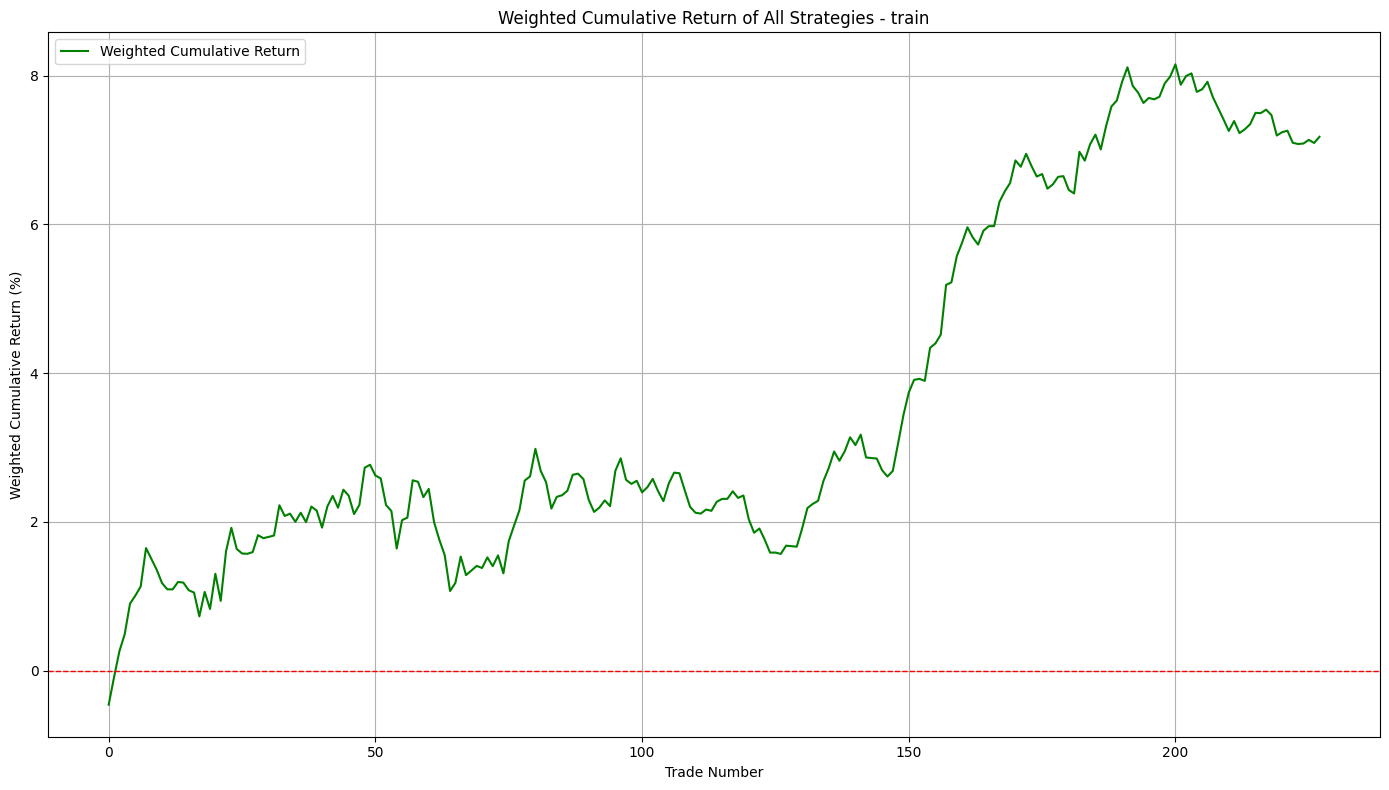

In [24]:
plot_cumulative_returns(train_pnls, optimal_weights, "train")

Processing strategies for tech sector...
AAPL MA Strategy PnLs: [1.3340605162198451, 0.7451162225039166, 1.0014149680162276, 0.048558190836609436, -0.6753502659310865, -0.31539966750099635, 0.14836067630176641, -3.654394033905307, 1.5892599518165658, 0.6121514854311884, 1.639831134956354]
AAPL BB Strategy PnLs: [-1.5347663596545529, -2.495724793288298, 0.5344200373569313, -2.5778407511573653, 1.0984472660762046, 2.3220788309763902, 0.26282558528469746, 0.21725634932599802, 2.914164788375385, 0.8851871910463718, 0.2621722070394426, 0.6486244749695309, -3.3948796901577456, -1.5072927091507438, 0.7535289904717793, 0.5345009028002677, 0.05314473407394489, -6.149985173224758, -2.1359337041983033]
MSFT MA Strategy PnLs: [1.5594319311505846, 3.2119336256292366, -3.378629359437388, -1.1286906926481572, 0.6850342867614063, 0.6806863644950546, 1.4424834962612554, 0.12354500620616936, 0.009236077600832532]
MSFT BB Strategy PnLs: [-0.48594441304228386, 1.257875620784213, 2.0695156845422673, 0.1467

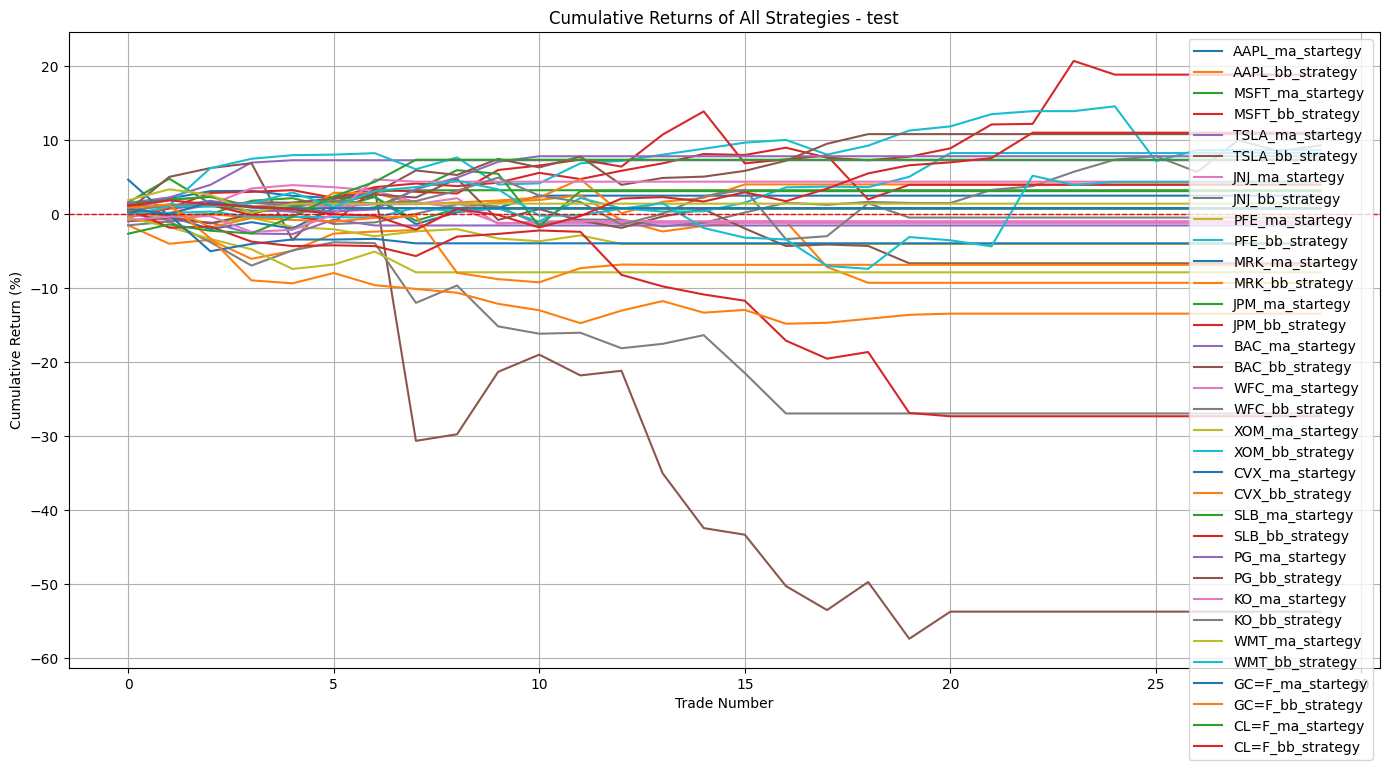

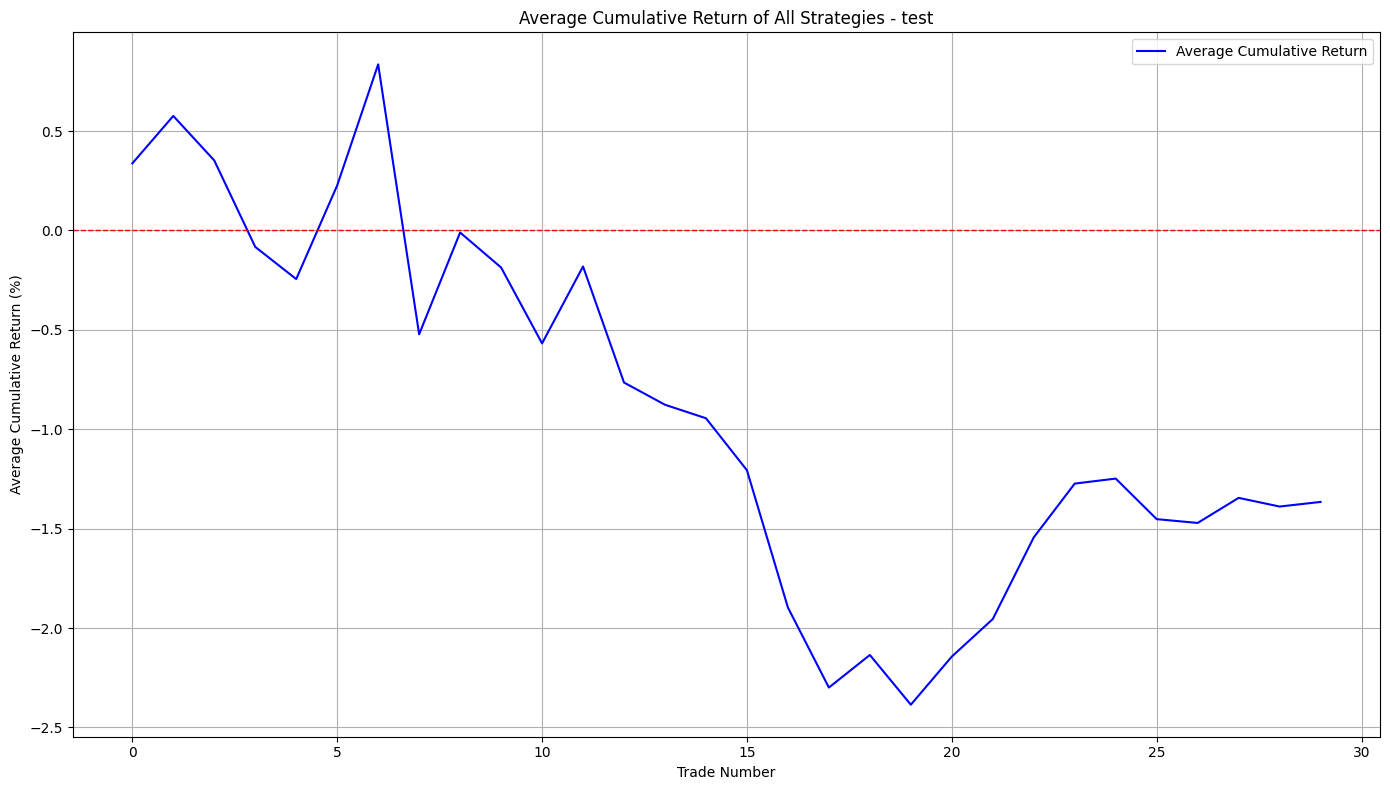

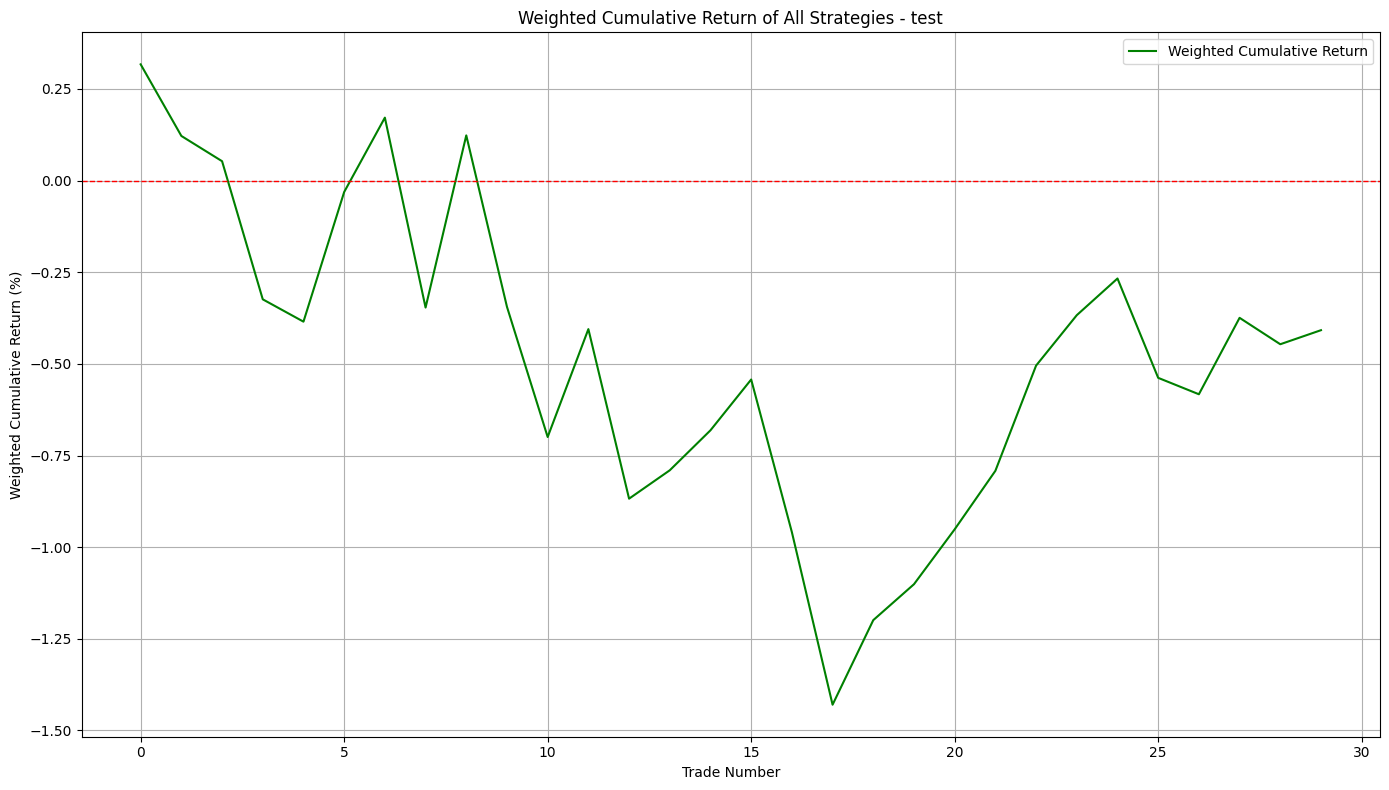

In [26]:
plot_cumulative_returns(generate_backtest_pnl("test"), optimal_weights, "test")